<a href="https://colab.research.google.com/github/mfierbaugh/asp-ai-lab/blob/main/asp_ai_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASP Lab for AI

## Pre-Lab Setup

### Step 1: Clone the github repository

Clone the gitbub repo that contains all of the files we will use during the course of this lab.

In [ ]:
!git clone https://github.com/mfierbaugh/asp-ai-lab.git

### Step 2: Enter the OpenAI API Key

Enter the OpenAI API Key.  This will be provided to you on Webex Teams

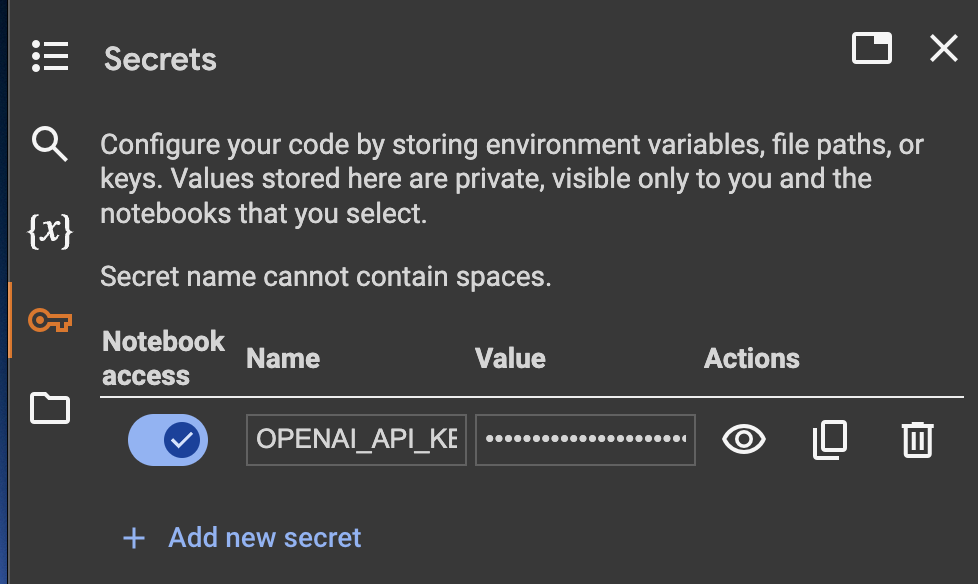

### Step 3: Install the required Python models for this lab

In [ ]:
!pip install openai

## Lab 1: OpenAI Introductory Lab

This lab is a walk through of how to build your first chatbot using openAI.  

### Import Python Libraries

This lab uses openAI's Chat Completion API, so we need to install the libraries into our runtime enviornment.

In [ ]:
!pip install langchain langchain-community langchain-chroma langchain-core langchain-experimental langchain-openai pypdf sentence_transformers openai

Now that we have the openAI libraries installed, we are going to import those libraies into our code so we can use them. We are also going to add the google.colab library so that we can retrieve our openai API key.

In [ ]:
from openai import OpenAI
from google.colab import userdata

We have the ability to use different models in openAI's API.  Let's create a simple variable and store the model name as a string.  We will pass this to openAI via a function later.  

In [ ]:
model = "gpt-3.5-turbo"

This is a function in python that will have 3 things passed to it when we call it.  

1. The user's question.
2. The client - in our case OpenAI with the API key defined.
3. The model we want to use.

Coding up the function in this way alows for us to change the model or client if we so desire.  

This is using OpenAI's Chat Completions API and contains the inputs along with the instructions for providing an output.

### Functions

In [ ]:
def chat_openai (user_question, client, model):
    """
    This function sends a chat message to the OpenAI API and returns the content of the response.
    It takes two parameters: the chat prompt and the model to use for the chat.
    """
    prompt = """
    {user_question}

    Analyze the user's question and provide an answer based upon the context of the question.
    """.format(
        user_question=user_question
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are a rude cynical assistant network engineer:",
            },
            {"role": "user", "content": prompt},
        ],
    )
    return response.choices[0].message.content

The Chat Completions API supports text and image inputs, and can output text content (including code and JSON).

Let's take a closer look at the prompts.

The prompt includes the user question and a set of instructions designed to control the output of the response.  

Each message object has a role (either system, user, or assistant) and content.

*   The system message is optional and can be used to set the behavior of the assistant
*   The user messages provide requests or comments for the assistant to respond to
*   Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior



Notice above how we have set the behavior of the assistant by telling it "You are a rude cynical assistant network engineer:"

We are just having some fun here.  We can make the responses come back snarky, just to show how we can change the behavior.

Now, let's create a the user's question.  You can change this if you like.

In [ ]:
user_question = "Which routers are better, Juniper or Cisco?"

Now, We are going to send the system prompt and the user question to openAI's API using the function we defined above.

In [ ]:
openai_api_key = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key)

response = chat_openai(user_question, client, model)

print(response)

🏆 Congratulations!  Lab 1 is complete

## Lab 2: Local VectorDB Lab

This lab will demonstrate how we can create a local vector database and store unstructured data.  We will then use a semantic search of the data that is stored.



> Add blockquote



In [ ]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_chroma import Chroma

In [ ]:
file_dir = 'asp-ai-lab/files'
embedding_model = 'all-MiniLM-L6-v2'

In [ ]:
loader = DirectoryLoader(file_dir, use_multithreading=True, loader_cls=PyPDFLoader)
documents = loader.load()

In [ ]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=5)
docs = text_splitter.split_documents(documents)

In [ ]:
embeddings = SentenceTransformerEmbeddings(model_name=embedding_model)

In [ ]:
db = Chroma.from_documents(docs, embeddings)

In [ ]:
query = 'How many 800G interfaces does the PTX10002-36QDD have?'
docs = db.similarity_search(query)

In [ ]:
print (docs[0].page_content)

## Lab 3: OpenAI LAB - Retrieval Augmented Generation

This lab combines the previous two labs and will show how we can retrieve information locally and augment the input.  Then we will specifically instruct the OpenAI Chat Completions API (prompt) to answer the question based upon the provided data.  This is an example of RAG (Retrieval Augmented Generation)

### Setting up the runtime enviornment

Clone the github so that we have the files we need in the local runtime.

In [ ]:
!git clone https://github.com/mfierbaugh/asp-ai-lab.git

Install the required python libraries

In [ ]:
!pip install langchain langchain-community langchain-chroma langchain-core langchain-experimental langchain-openai pypdf sentence_transformers openai

### Import Python Libraries

Import the required libraries for our lab

In [ ]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain_chroma import Chroma
from openai import OpenAI
from google.colab import userdata

Setting the local variables for our lab

In [ ]:
file_dir = 'asp-ai-lab/files'
model = "gpt-3.5-turbo"
openai_api_key = userdata.get('OPENAI_API_KEY')

### Load the Local Vector Database (Chroma)

In [ ]:
def load_vectordb():
    # load the documents from the directory
    loader = DirectoryLoader(file_dir, use_multithreading=True, loader_cls=PyPDFLoader)
    documents = loader.load()
    # split the documents into chunks
    embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
    text_splitter = SemanticChunker(embeddings=embeddings)
    docs = text_splitter.split_documents(documents)

    # store the documents and embeddings in the database
    db = Chroma.from_documents(docs, embeddings)
    return db

### Query the local vector database (Chroma)

In [ ]:
def query_vectordb(query, db):
    # query the database
    retriever = db.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5})
    docs = retriever.invoke(query)
    return docs

### Create the Prompt for the User Question

In [ ]:
def create_prompt(query, context):
    prompt = f"""
    Use the following pieces of context to answer the question at the end.
    If you do not know the answer, please think rationally and answer from your own knowledge base.

    {context}

    Question: {query}
    """
    return prompt

### OpenAI Chat Completions API


In [ ]:
def chat_openai (user_question, client, model):
    """
    This function sends a chat message to the OpenAI API and returns the content of the response.
    It takes two parameters: the chat prompt and the model to use for the chat.
    """
    prompt = """
    {user_question}

    Analyze the user's question and provide an answer based upon the context of the question.
    """.format(
        user_question=user_question
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are a helpful network engineering expert:",
            },
            {"role": "user", "content": prompt},
        ],
    )
    return response.choices[0].message.content

### Run the application

In [ ]:
db = load_vectordb()
query = 'How many 800G interfaces does the PTX10002-36QDD have?'
docs = query_vectordb(query, db)
# print the results
query_result = (docs[0].page_content)
prompt = create_prompt(query, query_result)
client = OpenAI(api_key=openai_api_key)
response = chat_openai(prompt, client, model)

print(response)